In [1]:
#matplotlib widget
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import MultipleLocator
import pandas as pd
from scipy import stats
import statsmodels.api as sm

from scipy.spatial import distance

import turboBrainUtils as tb 

def resample(x,y,n_bootstraps):
    x_bs = []
    y_bs = []
    sample_size = len(x)
    idx = range(sample_size) #[i for i in range(sample_size)]
    for b in range(n_bootstraps):
        # obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=sample_size)
        x_b = x[sidx]
        y_b = y[sidx]
        x_bs.append(x_b)
        y_bs.append(y_b)
    return x_bs,y_bs

def computeRegression(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    # Direct least square regression
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    return alpha

# Plot stuff

In [3]:
runs = 1000
passi = 100#200
autapse = True
randomize = False

def upper_tri_indexing(A):
    m = A.shape[0]
    print(m)
    r,c = np.triu_indices(m,1)
    print(r.shape)
    return A[r,c]

# # Parcellizzazione
# https://www.sciencedirect.com/science/article/pii/S2211124720314601?via%3Dihub
df = pd.read_csv('Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
df.head()
X = df['R']
Y = df['A']
Z = df['S']
N=len(X)

coords = np.array([X,Y,Z]).T
dist = distance.cdist(coords, coords, 'euclidean')
uniqDist,iListList,jListList = tb.sortIJbyDist(dist,N)

time ij list 2.0715525150299072


# Read states

In [4]:
# read states and load states container

df = pd.read_csv('lamdaValues-autapse.csv')
lambdas = np.unique(df['lambdas'].values)
print(lambdas)

binnedBds_mean = np.load('binnedBd_mean'+'-autapse'+'.npy')
binnedBds_std = np.load('binnedBd_std'+'-autapse'+'.npy')

binnedSds_mean = np.load('binnedSd_mean'+'-autapse'+'.npy')
binnedSds_std = np.load('binnedSd_std'+'-autapse'+'.npy')

binnedSds_random_mean = np.load('binnedSd_mean'+'-autapse-randomizeJ'+'.npy')
binnedSds_random_std = np.load('binnedSd_std'+'-autapse-randomizeJ'+'.npy')

print(binnedSds_random_mean[0,:])

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26]
[       nan        nan 0.00366667 0.00490997 0.00501059 0.00495921
 0.00502012 0.00499669 0.00504477 0.00502162 0.00510271 0.00499508
 0.00501799 0.00494823 0.00497856 0.00494224 0.00503553 0.00499217
 0.00502589 0.00502755 0.00498094 0.00503221 0.00500619 0.00497114
 0.00500291 0.00497791 0.00499432 0.0050502  0.00504458 0.0050035
 0.00499396 0.00499081 0.00505387 0.0050519  0.00495695 0.00498617
 0.00504062 0.00495591 0.00500391 0.0050194  0.00495511 0.00496305
 0.00500816 0.00497221 0.00502906 0.004946   0.00502316 0.00499101
 0.00499145 0.00501667 0.00502369 0.00496101 0.00502723 0.00497334
 0.00503343 0.00496912 0.00503899 0.00494353 0.00497389 0.00496367
 0.00503217 0.00496911 0.00496573 0.00500107 0.00500076 0.00500891
 0.00488708 0.00499389 0.00500725 0.00502897 0.00501873 0.00498732
 0.00492821 0.00504766 0.00500619 0.00504118 0.00504477 0.00489685
 0.00502284 0.00500692 0.00491334 0.005036

<IPython.core.display.Javascript object>


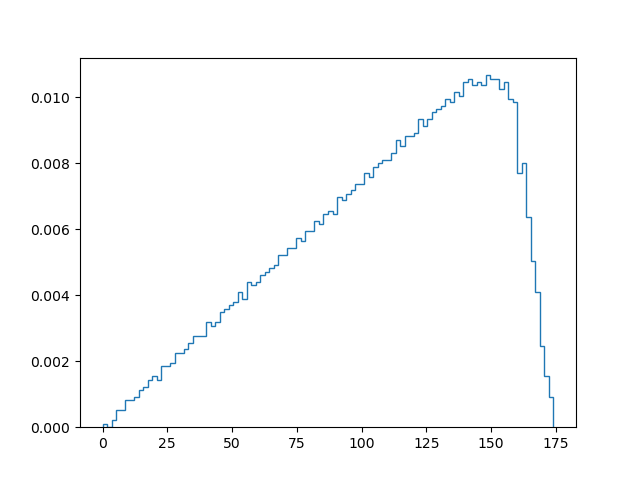

[8 7] [0.18 0.17] [5.55555556 5.88235294]


<IPython.core.display.Javascript object>


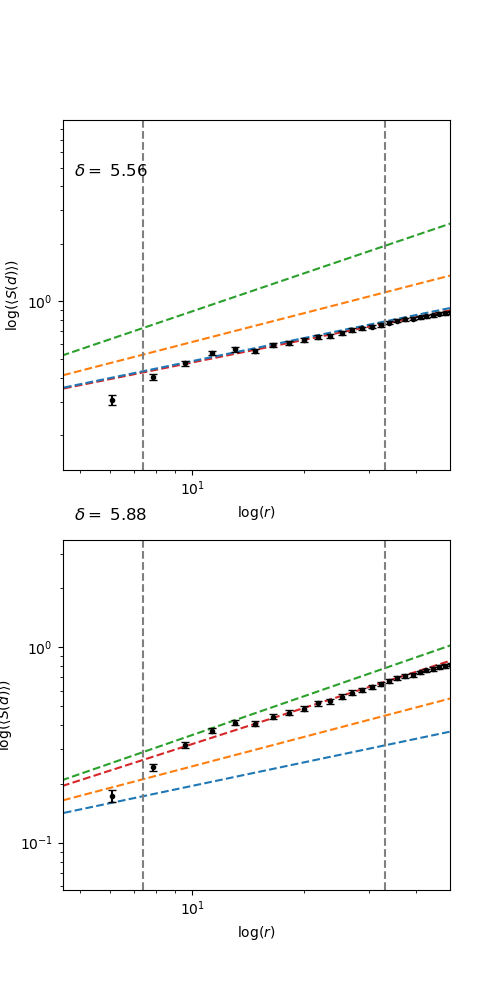

0 8
alpha0  0.39287864684758883
alpha1  -1.639567289693836


<IPython.core.display.Javascript object>


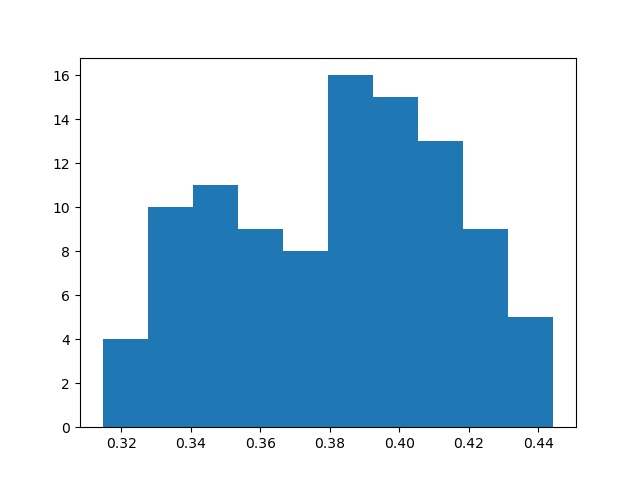

alpha 0.39287864684758883 2/5 0.4 2/3 0.6666666666666666
1 7
alpha0  0.6138652943376762
alpha1  -2.5546342958216126


<IPython.core.display.Javascript object>


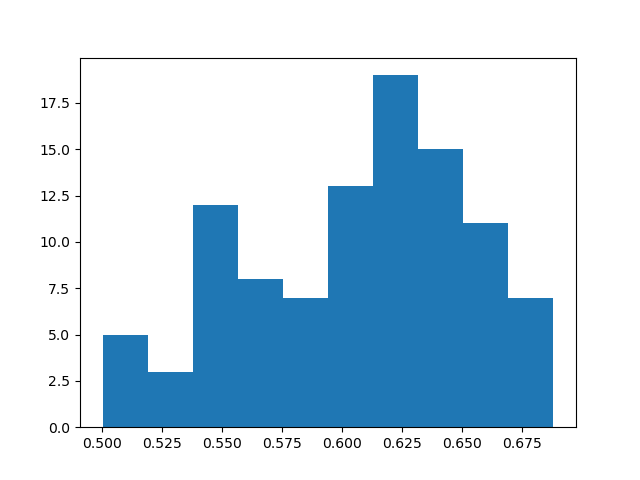

alpha 0.6138652943376762 2/5 0.4 2/3 0.6666666666666666


In [5]:
fitxlim = 3.5 
h,bins,f=plt.hist(uniqDist,bins=100,histtype="step", density=True)

#binnedSds_mean = np.load('binnedSd_mean'+'-autapse'+'.npy')
#binnedSds_std = np.load('binnedSd_std'+'-autapse'+'.npy')

linxs = np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(linxs,lambdas[linxs],1./lambdas[linxs])

f,axs = plt.subplots(2,1,figsize=(5,10))
rs = np.array([0.5*(ra+rb) for ra,rb in zip(bins[:-1],bins[1:])])

for i,lindx in enumerate(linxs):
    print(i,lindx)
    finiteIdx = np.isfinite(binnedSds_mean[lindx,:])
    rsTemp = rs[finiteIdx]#[:-2]#[finiteIdx]
    binnedSd_mean = binnedSds_mean[lindx,finiteIdx]
    binnedSd_std = binnedSds_std[lindx,finiteIdx]
    binnedSd_se = 3*binnedSd_std/np.sqrt(runs)
    
    x=np.log(rsTemp)
    y=np.log(binnedSd_mean)#[np.logical_and(x>2, x<4)]
    gate= np.logical_and(np.logical_and(x>2, x<fitxlim),np.isfinite(y))
    x=x[gate]
    y=y[gate]

    alpha = computeRegression(x,y)
    xbs,ybs = resample(x,y,n_bootstraps=100)
    alphas = [computeRegression(x,y) for x,y in zip(xbs,ybs)]
    print('alpha0 ',alpha[0])#,np.array(alphas)[:,0])
    print('alpha1 ',alpha[1])
    plt.figure()
    plt.hist(np.array(alphas)[:,0])
    
    xline = np.arange(1,5.5,0.1) #np.array([1,5.5])
    axs[i].plot(np.exp(xline), np.exp(alpha[0]*xline + alpha[1]), '--',color='tab:red',label='slope fit '+"%.2f" % alpha[0])
    
    
    
    axs[i].plot(np.exp([0,5.5]),np.exp([alpha[1],alpha[1] + 5.5*(0.4)]),'--',color='tab:blue',label='slope = 2/5')
    axs[i].plot(np.exp([0,5.5]),np.exp([alpha[1],alpha[1] + 5.5*(0.5)]),'--',color='tab:orange',label='slope = 1/2 Deco')
    axs[i].plot(np.exp([0,5.5]),np.exp([alpha[1],alpha[1] + 5.5*(0.66)]),'--',color='tab:green',label='slope = 2/3 Turbulence')
    axs[i].errorbar(rsTemp,binnedSd_mean,yerr=binnedSd_se.tolist(),fmt='k.', ecolor='black',  capsize=3, capthick=1)
    axs[i].axvline(np.exp(2),linestyle='--',color='gray')
    axs[i].axvline(np.exp(fitxlim),linestyle='--',color='gray')
    axs[i].set_xticks(np.exp(np.arange(1.5,3.9,0.5)))
    axs[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i].minorticks_off()
    axs[i].set_xticklabels(np.arange(1.5,3.9,0.5))
    axs[i].set_yticks(np.exp(np.arange(-2.,1.77,1.)))
    axs[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i].set_yticklabels(np.arange(-2.,1.77,1.))
    axs[i].set_xlim((np.exp(1.5),np.exp(3.9)))
    #axs[i].set_ylim((np.exp(-6),np.exp(1.77)))
    #axs[i].set_xlim((np.exp(1),np.exp(4)))
    axs[i].set_xlabel(r'$\log(r)$')
    axs[i].set_ylabel(r'$\log( \langle S(d) \rangle)$')
    axs[i].loglog()
    delt = 1./lambdas[lindx]
    axs[i].text(4.8, 4.5, r'$\delta = $ '+"%.2f" % delt, fontsize=12)
    print('alpha',alpha[0],'2/5',2./5.,'2/3',2./3.)
    SdDf = pd.DataFrame({'d': rsTemp,'binnedSd mean':binnedSd_mean,'binnedSd se':binnedSd_std})
    SdDf.to_csv('binnedSd_'+str(np.round(1./lambdas[lindx],2))+'.csv')
    

In [6]:
linxs = range(len(lambdas)-4,-1,-4)#np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(list(linxs))

[13, 9, 5, 1]


[11, 10, 9, 8, 7, 6, 5]


<IPython.core.display.Javascript object>


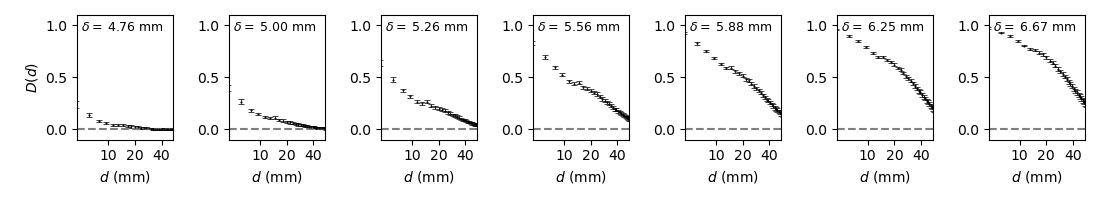

0 11
1 10
2 9
3 8
4 7
5 6
6 5


In [7]:
fitxlim = 3.5 
h,bins,f=plt.hist(uniqDist,bins=100,histtype="step", density=True)
rs = np.array([0.5*(ra+rb) for ra,rb in zip(bins[:-1],bins[1:])])

#binnedBds_mean = np.load('binnedBd_mean'+'-autapse'+'.npy')
#binnedBds_std = np.load('binnedBd_std'+'-autapse'+'.npy')

linxs = [11,10, 9, 8, 7, 6,5] #[12, 10, 8, 6, 4] #[16, 12, 8, 4, 0]#range(len(lambdas)-4,-1,-4)#np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(linxs)

f,axs = plt.subplots(1,7,figsize=(11,2))

for i,lindx in enumerate(linxs):
    print(i,lindx)
    finiteIdx = np.isfinite(binnedSds_mean[lindx,:])
    rsTemp = rs[finiteIdx]#[:-2]#[finiteIdx]
    binnedBd_mean = binnedBds_mean[lindx,finiteIdx]
    binnedBd_std = binnedBds_std[lindx,finiteIdx]
    binnedBd_se = 3*binnedBd_std/np.sqrt(runs)
    
    axs[i].errorbar(rsTemp,binnedBd_mean,yerr=binnedBd_se.tolist(),fmt='k.', markersize = 1. , ecolor='black', elinewidth=0.5 , capsize=2, capthick=.5)
    axs[i].set_xlim((np.exp(1.5),np.exp(4.)))
    axs[i].semilogx()
    axs[i].axhline(0.,linestyle='--',color='gray')
    #axs[i].axvline(np.exp(2),linestyle='--',color='gray')
    #axs[i].axvline(np.exp(fitxlim),linestyle='--',color='gray')
    axs[i].set_xticks([10,20,40])#([10,20,30,40])
    axs[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i].minorticks_off()
    axs[i].set_xticklabels([10,20,40])#([10,20,30,40])
    #axs[i].set_yticks(np.exp(np.arange(-2.,1.77,1.)))
    #axs[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #axs[i].set_yticklabels(np.arange(-2.,1.77,1.))
    axs[i].set_ylim((-0.1,1.1))
    #axs[i].set_xlim((np.exp(1),np.exp(4)))
    axs[i].set_xlabel(r'$d$ (mm)')
    delt = 1./lambdas[lindx]
    #axs[i].text(np.exp(.5), 1.,r'$\delta = $ '+"%.2f" % delt, fontsize=12)
    axs[i].text(5., .95, r'$\delta = $ '+"%.2f" % delt + ' mm', fontsize=9)

    
axs[0].set_ylabel(r'$D(d)$')
plt.tight_layout()

plt.savefig('BrforDelta2.png',dpi=600)

<IPython.core.display.Javascript object>


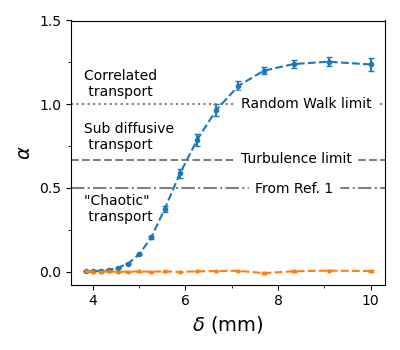

In [8]:
fitxlim = 3.5 

f,ax=plt.subplots(1,figsize=(4,3.5))
lambdas = np.unique(df['lambdas'].values)

#f,axs = plt.subplots(2,1,figsize=(5,10))
rs = np.array([0.5*(ra+rb) for ra,rb in zip(bins[:-1],bins[1:])])

def computeAlphaDelta(rs,binnedSds_mean,binnedSd_std,lambdas):
    
    linxs = range(len(lambdas))#np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
    #print(linxs)
    
    #alphaMean = []
    #alphaStd = []
    alphaMean2 = []
    alphaStd2 = []
    for lindx in linxs:
        #print(i,lindx)
        finiteIdx = np.isfinite(binnedSds_mean[lindx,:])
        rsTemp = rs[finiteIdx]#[:-2]#[finiteIdx]
        binnedSd_mean = binnedSds_mean[lindx,finiteIdx]
        binnedSd_std = binnedSds_std[lindx,finiteIdx]
        binnedSd_se = 3*binnedSd_std/np.sqrt(runs)

        x=np.log(rsTemp)
        y=np.log(binnedSd_mean)#[np.logical_and(x>2, x<4)]
        w=binnedSd_se/(binnedSd_mean)
        
        gate= np.logical_and(np.logical_and(x>2, x<fitxlim),np.isfinite(y))
        x=x[gate]
        y=y[gate]
        w=w[gate]
        X = sm.add_constant(x)

        #alpha = computeRegression(x,y)
        #xbs,ybs = resample(x,y,n_bootstraps=100)
        #alphas = [computeRegression(x,y) for x,y in zip(xbs,ybs)]
        #print('alpha0 ',alpha[0],np.std(np.array(alphas)[:,0]))

        model = sm.WLS(y,X, weights=1.0 / (w ** 2))
        results = model.fit()
        pars = results.params
        se = results.bse
        
        #alphaMean.append(np.mean(np.array(alphas)[:,0]))
        #alphaStd.append(np.std(np.array(alphas)[:,0]))
        alphaMean2.append( pars[1] )
        alphaStd2.append( se [1])
    #return alphaMean,alphaStd,alphaMean2,alphaStd2
    return alphaMean2,alphaStd2


alphaMean,alphaStd = computeAlphaDelta(rs,binnedSds_mean,binnedSd_std,lambdas)
random_alphaMean,random_alphaStd = computeAlphaDelta(rs,binnedSds_random_mean,binnedSds_random_std,lambdas)

plt.errorbar(1./lambdas, alphaMean, alphaStd,label=r'$J=\exp{(-\lambda r(i,j))}$', fmt='o', linestyle = '--',markersize=3, capsize=2)
#plt.errorbar(1./lambdas, alphaMean2, alphaStd2,label=r'$J=\exp{(-\lambda r(i,j))}$')
plt.errorbar(1./lambdas, random_alphaMean, random_alphaStd,label=r'$J=\exp{(-\lambda r(i,j))}$', fmt='o', linestyle = '--', markersize=2, capsize=2)
#plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
#plt.axvline(x = 0.18, color='r')
plt.axhline(y = 1.,linestyle=':', color='gray')
plt.axhline(y = 2./3.,linestyle='--', color='gray')
plt.axhline(y = 1./2.,linestyle='-.', color='gray')

plt.xticks([4,6,8,10])
ax.xaxis.set_minor_locator(MultipleLocator(1.))
plt.yticks([0.0,0.5,1.,1.5])#,minor=[0.0,0.25,0.5,0.75,1.,1.25,1.5])
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

#plt.yticks([0.0,0.25,0.5,0.75,1.,1.25,1.5])
plt.text(3.8,1.05,'Correlated \n transport')
plt.text(3.8,0.73,'Sub diffusive \n transport')
plt.text(3.8,0.3,'"Chaotic" \n transport')

plt.text(7.2,0.98,'Random Walk limit',backgroundcolor='white')
plt.text(7.2,0.65,'Turbulence limit',backgroundcolor='white')
plt.text(7.5,0.47,'From Ref. 1',backgroundcolor='white')

plt.ylabel(r'$\alpha$',fontsize=14)#('slope $\log S_2(r)$')
plt.xlabel(r'$\delta$ (mm)',fontsize=14)

plt.tight_layout()

alphaDf = pd.DataFrame({'delta': 1./lambdas,'alpha mean':alphaMean,'binnedSd std':alphaStd})
alphaDf.to_csv('alphaDelta-autapse.csv')

plt.savefig('alphaWithDelta.png',dpi=600)

20
[1.e-04 2.e-04 4.e-04 1.e-03 2.e-03 4.e-03 1.e-02 2.e-02 4.e-02 1.e-01
 2.e-01 4.e-01 8.e-01 9.e-01]


<IPython.core.display.Javascript object>


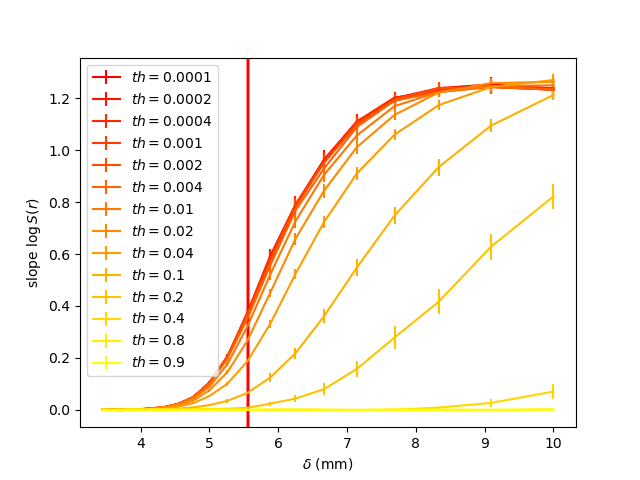

[10.          9.09090909  8.33333333  7.69230769  7.14285714  6.66666667
  6.25        5.88235294  5.55555556  5.26315789  5.          4.76190476
  4.54545455  4.34782609  4.16666667  4.          3.84615385  3.7037037
  3.57142857  3.44827586]


C:\Users\g_gos\AppData\Local\Temp\ipykernel_19336\3023241894.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTemp['alphaMean'] = alphaMean
C:\Users\g_gos\AppData\Local\Temp\ipykernel_19336\3023241894.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfDil = pd.concat([dfDil,dfTemp])
C:\Users\g_gos\AppData\Local\Temp\ipykernel_19336\3023241894.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

<IPython.core.display.Javascript object>


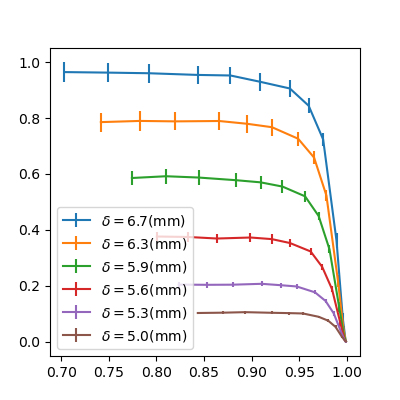

<IPython.core.display.Javascript object>


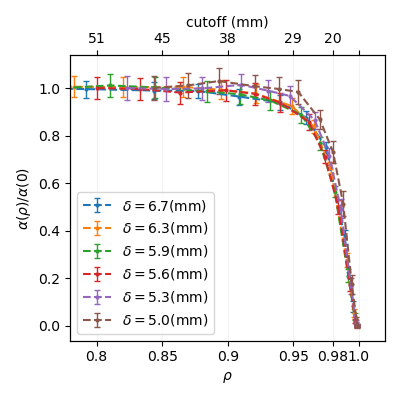

In [11]:
#df0 = pd.read_csv('parametersRuns-autapse-thJ.csv')
#df0 = pd.read_csv('lamdaValues-autapse-thJ.csv')
df = pd.read_csv('lamdaValues-autapse-thJ.csv')
#ths = np.unique(df['thsRuns'].values)
lambdas = np.unique(df['lambdas'].values)
print(len(lambdas))

ths = np.unique(df['thsRuns'].values)
print(ths)

f,ax1 = plt.subplots()
mycols= plt.cm.autumn(np.linspace(0,1,len(ths)))

dfDil = pd.DataFrame()

for i,th in enumerate(ths):
    #print(th)
    #print(df[df['thsRuns']==th])
    dfTh = df[(df['thsRuns']==th)*(df['run']==0)]
    dfTemp = dfTh[['thsRuns','dilsRuns']]

    #lambdas = np.unique(dfTh['lambdas'].values)
    #print(len(lambdas))
    binnedSds_mean = np.load('binnedSd_mean'+'-autapse-thJ-'+str(th)+'.npy')
    binnedSds_std = np.load('binnedSd_std'+'-autapse-thJ-'+str(th)+'.npy')
    #print('binnedSds_mean',binnedSds_mean.shape,len(lambdas))
    
    alphaMean,alphaSe = computeAlphaDelta(rs,binnedSds_mean,binnedSd_std,lambdas)
    dfTemp['alphaMean'] = alphaMean
    dfTemp['alphaSe'] = alphaSe
    dfTemp['delta'] = 1./lambdas
    #print(dfTemp)
    if len(dfDil.columns)==0: 
        dfDil= pd.DataFrame(columns= dfTemp.columns)
    #print(dfDil)
    dfDil = pd.concat([dfDil,dfTemp])

    ax1.errorbar(1./lambdas, alphaMean, alphaSe,label=r'$th=$'+str(th), color=mycols[i])
    #plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    ax1.axvline(x = 1./0.18, color='r')
    ax1.set_ylabel('slope $\log S(r)$')
    ax1.set_xlabel(r'$\delta$ (mm)')
    ax1.legend()

deltas = 1./np.unique(df['lambdas'].values)
print(deltas)

f,ax0 = plt.subplots(figsize=(4,4))
f,ax2 = plt.subplots(figsize=(4,4))
for i,delta in enumerate(deltas):
    #print(delta)
    #print(df[df['thsRuns']==th])
    if (delta > 5.) and (delta < 7.): 
        dfdlt = dfDil[dfDil['delta']==delta]
        #print(dfdlt)
        dils = dfdlt['dilsRuns'].values
        alphaMean =  dfdlt['alphaMean'].values 
        alphaSe = dfdlt['alphaSe'].values 
        alphaNormMean = alphaMean/alphaMean[0]
        alphaNormSe =  alphaSe/alphaMean[0]
        ax0.errorbar(dils, alphaMean, alphaSe, label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')
        ax2.errorbar(dils,alphaNormMean, np.array(alphaNormSe), marker='.',linestyle='--', 
                     markersize = 4. , elinewidth=1. , capsize=2, capthick=1.,
                     label=r'$\delta=$'+str(np.round(delta,1))+'(mm)',)

ax0.legend()

ax2.set_ylabel(r'$\alpha(\rho)/\alpha(0)$')
ax2.set_xlabel(r'$\rho$')
ax2.legend()
ax2.grid(axis='x', color='0.95')
ax2b = ax2.twiny()
ax2.set_xticks([0.70,0.75,0.80,0.85,0.90,0.95,0.98,1.0])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.minorticks_off()
ax2.set_xticklabels([0.70,0.75,0.80,0.85,0.90,0.95,0.98,1.0])
#ax2b.set_xticks([0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.0,1.05])
#ax2b.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax2b.minorticks_off()
ax2b.set_xticks([0.70,0.75,0.80,0.85,0.90,0.95,0.98,1.0])
ax2b.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2b.minorticks_off()

def upper_tri_indexing(A):
    m = A.shape[0]
    #print(m)
    r,c = np.triu_indices(m,1)
    #print(r.shape)
    return A[r,c]

distUT = upper_tri_indexing(dist)
distSort = distUT.tolist()
distSort.sort()

distTh = [np.round(distSort[-int(499500*dil)],1) for dil in [0.70,0.75,0.80,0.85,0.90,0.95,0.98]]
distTh2 = ['%s' % int('%.2g' % d) for d in distTh]+['']
ax2b.set_xticklabels(distTh2)
ax2.set_xlim((0.78,1.02))
ax2b.set_xlim((0.78,1.02))
ax2b.set_xlabel(r'cutoff (mm)')
#ax2b.set_xlim((distSort[-int(499500*0.68)],distSort[-int(499500*1.02)]))
plt.tight_layout()

plt.savefig('normDilutionScalePar_delta3.png',dpi=600)

<IPython.core.display.Javascript object>


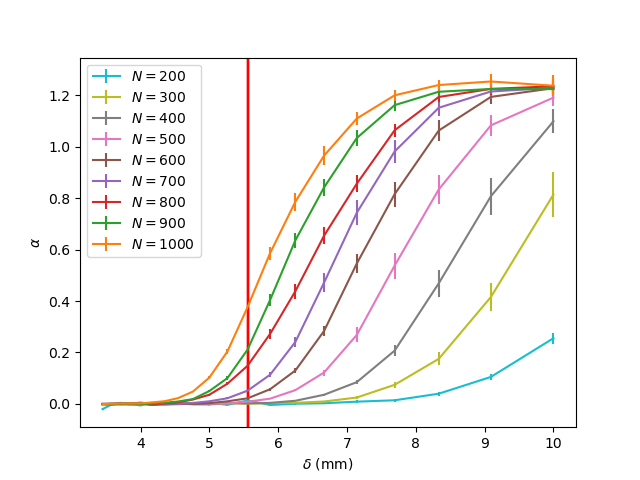

In [12]:
#df0 = pd.read_csv('parametersRuns-autapse-thJ.csv')
#df0 = pd.read_csv('lamdaValues-autapse-thJ.csv')
df = pd.read_csv('lamdaValues-autapse-N.csv')
#print(df)
#ths = np.unique(df['thsRuns'].values)
lambdas = np.unique(df['lambdas'].values)
#print(lambdas,len(lambdas))

Ns = np.unique(df['N'].values)
#print(Ns)

f,ax1 = plt.subplots()
mycols= plt.cm.tab10(np.linspace(1,0,len(Ns)))#autumn(np.linspace(0,1,len(ths)))

dfDil = pd.DataFrame()

for i,N in enumerate(Ns[1:]):
    #print(N)
    #print(df[df['N']==N])
    #dfN = df[(df['N']==N)*(df['run']==0)]
    #dfTemp = dfTh[['N']]

    #lambdas = np.unique(dfTh['lambdas'].values)
    #print(len(lambdas))
    binnedSds_mean = np.load('binnedSd_mean'+'-autapse-N-'+str(N)+'.npy')
    binnedSds_std = np.load('binnedSd_std'+'-autapse-N-'+str(N)+'.npy')
    #print('binnedSds_mean',binnedSds_mean.shape,len(lambdas))
    #print('binnedSds_std',binnedSds_std.shape,len(lambdas))
    #print(binnedSds_std)
    
    alphaMean,alphaSe = computeAlphaDelta(rs,binnedSds_mean,binnedSd_std,lambdas)
    #dfTemp['alphaMean'] = alphaMean
    #dfTemp['alphaSe'] = alphaSe
    #dfTemp['delta'] = 1./lambdas
    #print(dfTemp)
    #if len(dfDil.columns)==0: 
    #    dfDil= pd.DataFrame(columns= dfTemp.columns)
    #print(dfDil)
    #dfDil = pd.concat([dfDil,dfTemp])

    ax1.errorbar(1./lambdas, alphaMean, alphaSe,label=r'$N=$'+str(N), color=mycols[i])
    #plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    ax1.axvline(x = 1./0.18, color='r')
    ax1.set_ylabel(r'$\alpha$')
    ax1.set_xlabel(r'$\delta$ (mm)')
    ax1.legend()

plt.savefig('alphaWithDelta_diffN.png',dpi=600)

In [13]:
len(ths)

14

In [14]:
alphaUpperLimit = []


N = 1000

binnedSds_mean = np.load('binnedSd_mean'+'-autapse-N-'+str(N)+'.npy')
binnedSds_std = np.load('binnedSd_std'+'-autapse-N-'+str(N)+'.npy')
#print('binnedSds_mean',binnedSds_mean.shape,len(lambdas))
#print('binnedSds_std',binnedSds_std.shape,len(lambdas))
#print(binnedSds_std)

alphaMean,alphaSe = computeAlphaDelta(rs,binnedSds_mean,binnedSd_std,lambdas)
alphaUpperLimit = alphaMean[:3]

N = 900

binnedSds_mean = np.load('binnedSd_mean'+'-autapse-N-'+str(N)+'.npy')
binnedSds_std = np.load('binnedSd_std'+'-autapse-N-'+str(N)+'.npy')
#print('binnedSds_mean',binnedSds_mean.shape,len(lambdas))
#print('binnedSds_std',binnedSds_std.shape,len(lambdas))
#print(binnedSds_std)

alphaMean,alphaSe = computeAlphaDelta(rs,binnedSds_mean,binnedSd_std,lambdas)

alphaUpperLimit = alphaUpperLimit + alphaMean[:3]

N = 800

binnedSds_mean = np.load('binnedSd_mean'+'-autapse-N-'+str(N)+'.npy')
binnedSds_std = np.load('binnedSd_std'+'-autapse-N-'+str(N)+'.npy')
#print('binnedSds_mean',binnedSds_mean.shape,len(lambdas))
#print('binnedSds_std',binnedSds_std.shape,len(lambdas))
#print(binnedSds_std)

alphaMean,alphaSe = computeAlphaDelta(rs,binnedSds_mean,binnedSd_std,lambdas)

alphaUpperLimit = alphaUpperLimit + alphaMean[:2]
Lhat = np.mean(alphaUpperLimit)
print('Lhat',Lhat)

Lhat 1.2316593380801195


<IPython.core.display.Javascript object>


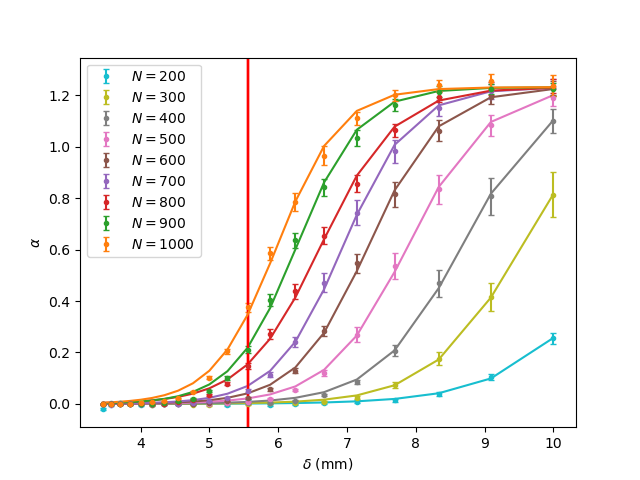

In [15]:
from scipy.optimize import curve_fit

def sigmoid(x, x0, k, L=Lhat,b=0):
    y = b + L / (1 + np.exp(-k*(x-x0))) 
    return (y)
#def sigmoid(x, L ,x0, k, b):
#    y = L / (1 = 1/(k*(x-x0))) + b
#    return (y)
#p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
p0 = [7,10] # this is an mandatory initial guess
popts = []



#df0 = pd.read_csv('parametersRuns-autapse-thJ.csv')
#df0 = pd.read_csv('lamdaValues-autapse-thJ.csv')
df = pd.read_csv('lamdaValues-autapse-N.csv')
#print(df)
#ths = np.unique(df['thsRuns'].values)
lambdas = np.unique(df['lambdas'].values)
#print(lambdas,len(lambdas))

Ns = np.unique(df['N'].values)
#print(Ns)

f,ax1 = plt.subplots()
mycols= plt.cm.tab10(np.linspace(1,0,len(Ns)))#autumn(np.linspace(0,1,len(ths)))

dfDil = pd.DataFrame()

for i,N in enumerate(Ns[1:]):
    #print(N)
    #print(df[df['N']==N])
    #dfN = df[(df['N']==N)*(df['run']==0)]
    #dfTemp = dfTh[['N']]

    #lambdas = np.unique(dfTh['lambdas'].values)
    #print(len(lambdas))
    binnedSds_mean = np.load('binnedSd_mean'+'-autapse-N-'+str(N)+'.npy')
    binnedSds_std = np.load('binnedSd_std'+'-autapse-N-'+str(N)+'.npy')
    #print('binnedSds_mean',binnedSds_mean.shape,len(lambdas))
    #print('binnedSds_std',binnedSds_std.shape,len(lambdas))
    #print(binnedSds_std)
    
    alphaMean,alphaSe = computeAlphaDelta(rs,binnedSds_mean,binnedSd_std,lambdas)
    #dfTemp['alphaMean'] = alphaMean
    #dfTemp['alphaSe'] = alphaSe
    #dfTemp['delta'] = 1./lambdas
    #print(dfTemp)
    #if len(dfDil.columns)==0: 
    #    dfDil= pd.DataFrame(columns= dfTemp.columns)
    #print(dfDil)
    #dfDil = pd.concat([dfDil,dfTemp])
    deltas = 1./lambdas
    x,y,sigma = deltas[:], alphaMean[:], alphaSe[:]
    ax1.errorbar(x, y, sigma,label=r'$N=$'+str(N), color=mycols[i], fmt='o',markersize=3, capsize=2)
    #plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    ax1.axvline(x = 1./0.18, color='r')
    ax1.set_ylabel(r'$\alpha$')
    ax1.set_xlabel(r'$\delta$ (mm)')
    ax1.legend()

    #print(deltas.shape)
    #print(np.array(alphaMean).shape)
    #print(sigmoid(deltas,*p0)-np.array(alphaMean))
    #popt, pcov = curve_fit(sigmoid, deltas, alphaMean,p0, sigma= alphaSe, method='dogbox')
    popt, pcov = curve_fit(sigmoid, x, y,p0, method='dogbox')
    ax1.plot(x,sigmoid(x, *popt), color=mycols[i])
    popts.append(popt)

#plt.savefig('alphaWithDelta_diffN.png',dpi=600)

<IPython.core.display.Javascript object>


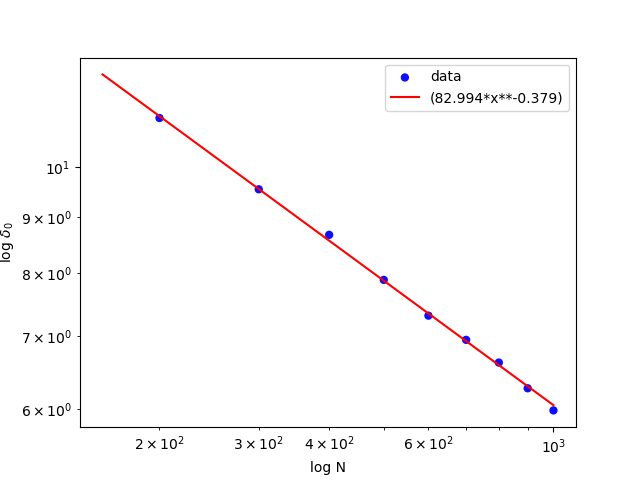

Exponential Fit: y = (a*(x**b))


<IPython.core.display.Javascript object>


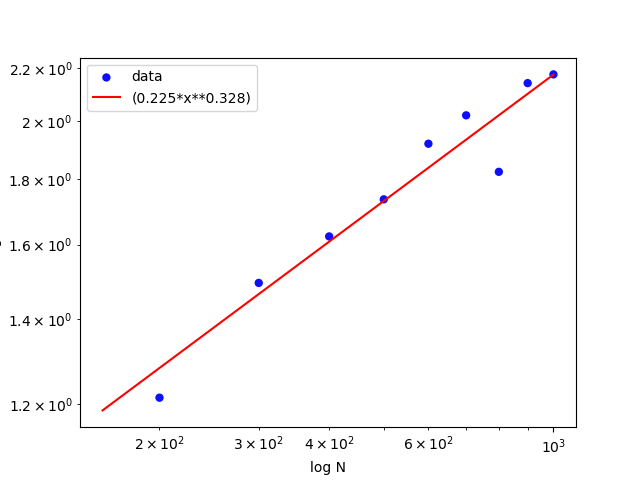

Exponential Fit: y = (a*(x**b))


Text(0.5, 0, 'log N')

In [16]:
popts = np.array(popts)

x = Ns[1:]
y = popts[:,0]

fig = plt.figure()
ax=plt.gca() 
ax.scatter(x,y,c="blue",alpha=0.95,edgecolors='none', label='data')
ax.set_yscale('log')
ax.set_xscale('log')


newX = np.logspace(2.2, 3, base=10)  # Makes a nice domain for the fitted curves.
                                   # Goes from 10^0 to 10^3
                                   # This avoids the sorting and the swarm of lines.

# Let's fit an exponential function.  
# This looks like a line on a lof-log plot.
def myExpFunc(x, a, b):
    return a * np.power(x, b)
popt, pcov = curve_fit(myExpFunc, x, y)
plt.plot(newX, myExpFunc(newX, *popt), 'r-', 
         label="({0:.3f}*x**{1:.3f})".format(*popt))
plt.legend()
print("Exponential Fit: y = (a*(x**b))")

ax.set_ylabel(r'log $\delta_0$')
ax.set_xlabel('log N')


x = Ns[1:]
y = popts[:,1]

fig = plt.figure()
ax=plt.gca() 
ax.scatter(x,y,c="blue",alpha=0.95,edgecolors='none', label='data')
ax.set_yscale('log')
ax.set_xscale('log')


newX = np.logspace(2.2, 3, base=10)  # Makes a nice domain for the fitted curves.
                                   # Goes from 10^0 to 10^3
                                   # This avoids the sorting and the swarm of lines.

# Let's fit an exponential function.  
# This looks like a line on a lof-log plot.
def myExpFunc(x, a, b):
    return a * np.power(x, b)
popt, pcov = curve_fit(myExpFunc, x, y)
plt.plot(newX, myExpFunc(newX, *popt), 'r-', 
         label="({0:.3f}*x**{1:.3f})".format(*popt))
plt.legend()
print("Exponential Fit: y = (a*(x**b))")

ax.set_ylabel(r'log k')
ax.set_xlabel('log N')

In [129]:
popts[:,0]

TypeError: list indices must be integers or slices, not tuple

In [17]:
import numpy as np
import pyvista as pv
point_cloud = np.random.random((100, 3))
pdata = pv.PolyData(point_cloud)
pdata['orig_sphere'] = np.arange(100)
sphere = pv.Sphere(radius=0.02)
pc = pdata.glyph(scale=False, geom=sphere, orient=False)
pl = pv.Plotter()
_ = pl.add_mesh(
    pc,
    cmap='reds',
    smooth_shading=True,
    show_scalar_bar=False,
)
pl.export_gltf('balls.gltf')  
pl.show()

Widget(value='<iframe src="http://localhost:49618/index.html?ui=P_0x1af8fc0cdd0_0&reconnect=auto" class="pyvis…

<IPython.core.display.Javascript object>


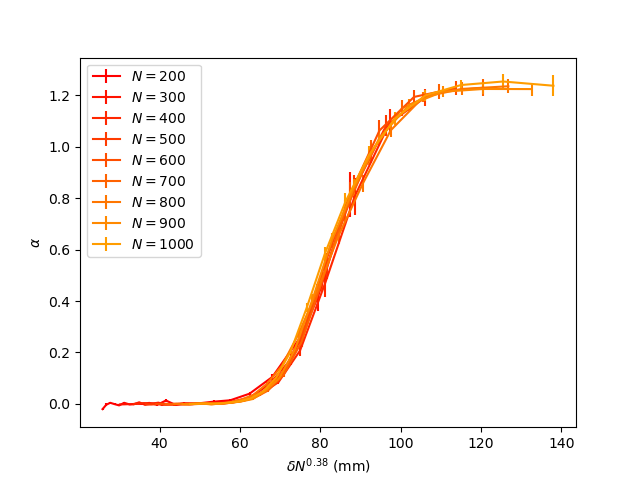

In [10]:
#df0 = pd.read_csv('parametersRuns-autapse-thJ.csv')
#df0 = pd.read_csv('lamdaValues-autapse-thJ.csv')
df = pd.read_csv('lamdaValues-autapse-N.csv')
#print(df)
#ths = np.unique(df['thsRuns'].values)
lambdas = np.unique(df['lambdas'].values)
#print(lambdas,len(lambdas))

Ns = np.unique(df['N'].values)
#print(Ns)

f,ax1 = plt.subplots()
mycols= plt.cm.autumn(np.linspace(0,1,len(ths)))

dfDil = pd.DataFrame()

for i,N in enumerate(Ns[1:]):
    #print(N)
    #print(df[df['N']==N])
    #dfN = df[(df['N']==N)*(df['run']==0)]
    #dfTemp = dfTh[['N']]

    #lambdas = np.unique(dfTh['lambdas'].values)
    #print(len(lambdas))
    binnedSds_mean = np.load('binnedSd_mean'+'-autapse-N-'+str(N)+'.npy')
    binnedSds_std = np.load('binnedSd_std'+'-autapse-N-'+str(N)+'.npy')
    #print('binnedSds_mean',binnedSds_mean.shape,len(lambdas))
    #print('binnedSds_std',binnedSds_std.shape,len(lambdas))
    #print(binnedSds_std)
    
    alphaMean,alphaSe = computeAlphaDelta(rs,binnedSds_mean,binnedSd_std,lambdas)
    #dfTemp['alphaMean'] = alphaMean
    #dfTemp['alphaSe'] = alphaSe
    #dfTemp['delta'] = 1./lambdas
    #print(dfTemp)
    #if len(dfDil.columns)==0: 
    #    dfDil= pd.DataFrame(columns= dfTemp.columns)
    #print(dfDil)
    #dfDil = pd.concat([dfDil,dfTemp])

    ax1.errorbar((N**(0.38))*(lambdas**(-1)), alphaMean, alphaSe,label=r'$N=$'+str(N), color=mycols[i])
    #plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    #ax1.axvline(x = 1./0.18, color='r')
    ax1.set_ylabel(r'$\alpha$')
    ax1.set_xlabel(r'$\delta N^{0.38} $ (mm)')
    ax1.legend()

plt.savefig('alphaWithScaledDelta_diffN.png',dpi=600)

In [39]:
N

1000

In [44]:
5.7 * (N**(0.38))

78.68190308236443

In [45]:
5.7 * (10000**(0.38))

188.74473924507694

In [7]:
lambdas[9]

0.1899999999999999

<IPython.core.display.Javascript object>


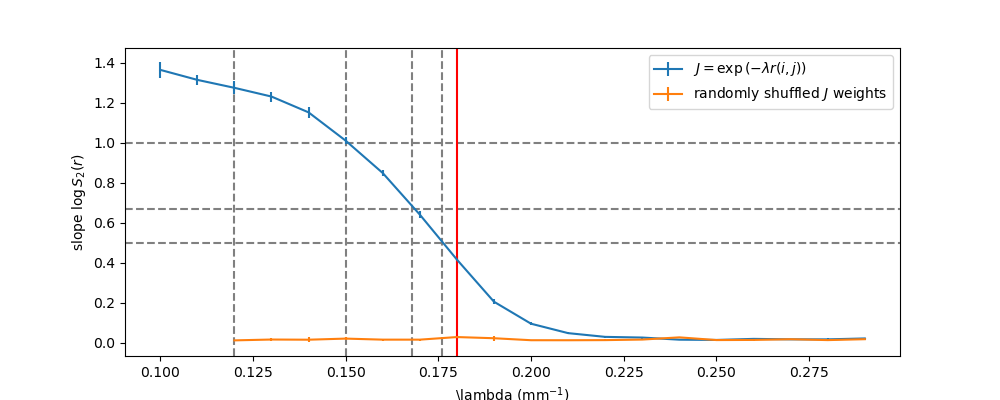

/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeW

In [8]:
f,ax=plt.subplots(1,figsize=(10,4))

df = pd.read_csv('parametersRuns-autapse.csv')
dfRand = pd.read_csv('parametersRuns-autapse-randomizeJ.csv')

lambdas = np.unique(df['lambdas'].values)

alphaMean = []
alphaSe = []
for lamd in lambdas:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphas = df[df['lambdas'] == lamd]['alphaRuns'].values
    alphas = alphas[np.isfinite(alphas)]
    #print(alphas)
    n = len(alphas)
    #print('n',n)
    alphaMean.append(np.mean(alphas))
    alphaSe.append(stats.sem(alphas))

lambdasRand = np.unique(dfRand['lambdas'].values)

alphaMeanRand = []
alphaSeRand = []
for lamd in lambdasRand:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphasRand = dfRand[dfRand['lambdas'] == lamd]['alphaRuns'].values
    alphasRand = alphasRand[np.isfinite(alphasRand)]
    #print(alphasRand)
    n = len(alphasRand)
    #print('n',n)
    alphaMeanRand.append(np.mean(alphasRand))
    alphaSeRand.append(stats.sem(alphasRand))
    
#plt.figure()

plt.axhline(y = 1., color='gray',linestyle='--')
plt.axhline(y = 2./3., color='gray',linestyle='--')
plt.axhline(y = 1./2., color='gray',linestyle='--')

plt.axvline(x = 0.12, color='gray',linestyle='--')
plt.axvline(x = 0.15, color='gray',linestyle='--')
plt.axvline(x = 0.168, color='gray',linestyle='--')
plt.axvline(x = 0.176, color='gray',linestyle='--')

plt.errorbar(lambdas, alphaMean, alphaSe,label=r'$J=\exp{(-\lambda r(i,j))}$')
plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
plt.axvline(x = 0.18, color='r')



plt.ylabel('slope $\log S_2(r)$')
plt.xlabel('\lambda (mm$^{-1}$)')
plt.legend()
#plt.savefig('lambdaVsSlope-wShaffled2.png',dpi=600)

<IPython.core.display.Javascript object>


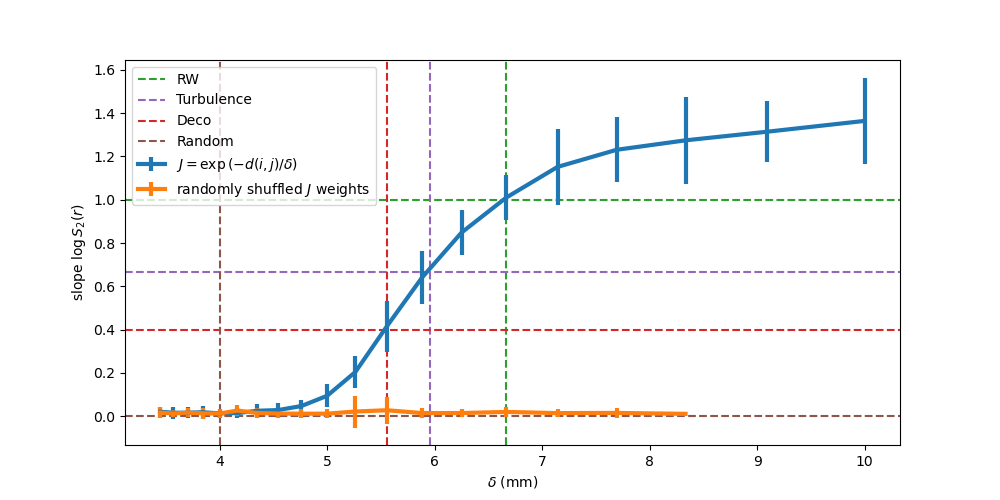

/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeW

In [12]:
from matplotlib.cm import get_cmap

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

f,ax=plt.subplots(1,figsize=(10,5))

df = pd.read_csv('parametersRuns-autapse.csv')
dfRand = pd.read_csv('parametersRuns-autapse-randomizeJ.csv')

lambdas = np.unique(df['lambdas'].values)

alphaMean = []
alphaSe = []
alphaStd = []
for lamd in lambdas:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphas = df[df['lambdas'] == lamd]['alphaRuns'].values
    alphas = alphas[np.isfinite(alphas)]
    #print(alphas)
    n = len(alphas)
    #print('n',n)
    alphaMean.append(np.mean(alphas))
    alphaSe.append(stats.sem(alphas))
    alphaStd.append(np.std(alphas))

lambdasRand = np.unique(dfRand['lambdas'].values)

alphaMeanRand = []
alphaSeRand = []
alphaStdRand = []
for lamd in lambdasRand:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphasRand = dfRand[dfRand['lambdas'] == lamd]['alphaRuns'].values
    alphasRand = alphasRand[np.isfinite(alphasRand)]
    #print(alphasRand)
    n = len(alphasRand)
    #print('n',n)
    alphaMeanRand.append(np.mean(alphasRand))
    alphaSeRand.append(stats.sem(alphasRand))
    alphaStdRand.append(np.std(alphasRand))
    
#plt.figure()

plt.axhline(y = 1., color=colors[2],label='RW',linestyle='--')
#plt.axhline(y = 1./2., color='gray',linestyle='--')

#plt.axvline(x = 1/0.12, color='gray',linestyle='--')
plt.axvline(x = 1/0.15, color=colors[2],linestyle='--')
plt.axhline(y = 2./3., color=colors[4],label='Turbulence',linestyle='--')
plt.axvline(x = 1/0.168, color=colors[4],linestyle='--')
#plt.axvline(x = 1/0.176, color='gray',linestyle='--')

plt.axhline(y = 2./5., color=colors[3],linestyle='--',label='Deco')
plt.axvline(x = 1/0.18, color=colors[3],linestyle='--')

plt.axhline(y = 0., color=colors[5],linestyle='--',label='Random')
plt.axvline(x = 1/0.25, color=colors[5],linestyle='--')

plt.errorbar(1./lambdas, alphaMean, alphaStd,label=r'$J=\exp{(-d(i,j)/\delta)}$',color=colors[0],linewidth=3.)
plt.errorbar(1./lambdasRand, alphaMeanRand, alphaStdRand, label=r'randomly shuffled $J$ weights',color=colors[1],linewidth=3.)




plt.ylabel('slope $\log S_2(r)$')
plt.xlabel(r'$\delta$ (mm)')
plt.legend()
#plt.savefig('deltaVsSlope-wShaffled2.png',dpi=600)

alphaDf = pd.DataFrame({'delta': 1./lambdas,'alphaMean':alphaMean,'alphaStd':alphaStd})
alphaDf.to_csv('alphaExpJ.csv')
alphaDfRand = pd.DataFrame({'delta': 1./lambdasRand,'alphaMean':alphaMeanRand,'alphaStd':alphaStdRand})
alphaDfRand.to_csv('alphaExpJ_Shuffled.csv')

<IPython.core.display.Javascript object>


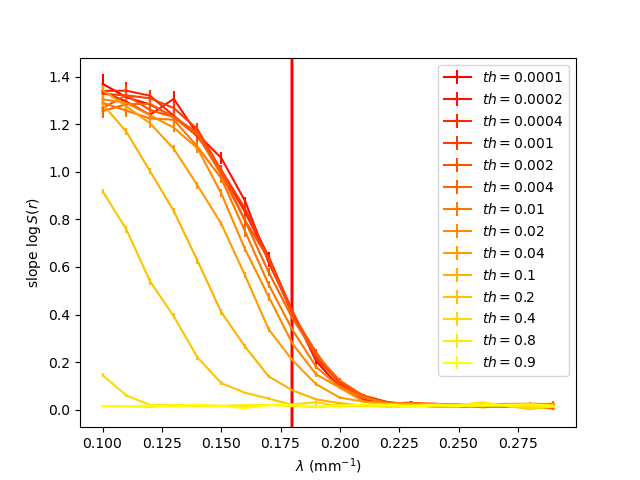

<IPython.core.display.Javascript object>


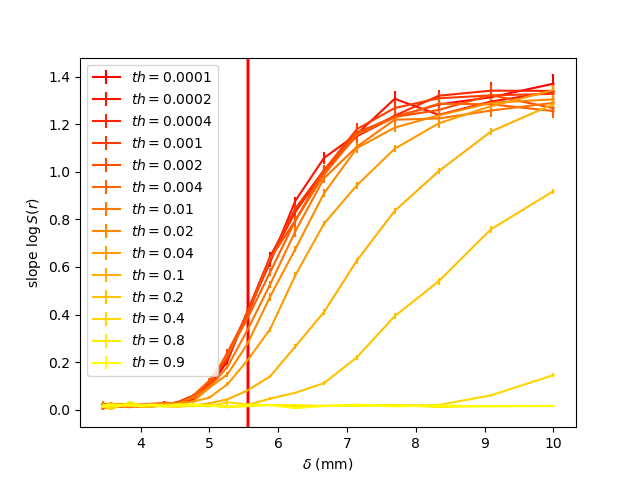

In [20]:
df = pd.read_csv('parametersRuns-autapse-thJ.csv')


ths = np.unique(df['thsRuns'].values)

f,ax0 = plt.subplots()
f,ax1 = plt.subplots()
mycols= plt.cm.autumn(np.linspace(0,1,len(ths)))

for i,th in enumerate(ths):
    #print(th)
    #print(df[df['thsRuns']==th])
    dfTh = df[df['thsRuns']==th]
    lambdas = np.unique(dfTh['lambdas'].values)
    alphaMean = []
    alphaSe = []
    for lamd in lambdas:
        #print(lamd)
        #print(df[df['lambdas'] == lamd]['alphaRuns'])
        alphas = dfTh[dfTh['lambdas'] == lamd]['alphaRuns'].values
        alphas = alphas[np.isfinite(alphas)]
        #print(alphas)
        n = len(alphas)
        #print('n',n)
        alphaMean.append(np.mean(alphas))
        alphaSe.append(stats.sem(alphas))

    ax0.errorbar(lambdas, alphaMean, alphaSe,label=r'$th=$'+str(th), color=mycols[i])
    #plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    ax0.axvline(x = 0.18, color='r')
    ax0.set_ylabel('slope $\log S(r)$')
    ax0.set_xlabel(r'$\lambda$ (mm$^{-1}$)')
    ax0.legend()
    
    ax1.errorbar(1./lambdas, alphaMean, alphaSe,label=r'$th=$'+str(th), color=mycols[i])
    #plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    ax1.axvline(x = 1./0.18, color='r')
    ax1.set_ylabel('slope $\log S(r)$')
    ax1.set_xlabel(r'$\delta$ (mm)')
    ax1.legend()



In [37]:
df.head(10)

,thsRuns,alphaRuns,lambdas,dilsRuns,run,deltas
0,0.0001,1.384045,0.1,0.368432,0,10.0
1,0.0001,1.366732,0.1,0.368432,1,10.0
2,0.0001,1.708016,0.1,0.368432,2,10.0
3,0.0001,1.218943,0.1,0.368432,3,10.0
4,0.0001,NaN,0.1,0.368432,4,10.0
5,0.0001,NaN,0.1,0.368432,5,10.0
6,0.0001,1.305027,0.1,0.368432,6,10.0
7,0.0001,NaN,0.1,0.368432,7,10.0
8,0.0001,NaN,0.1,0.368432,8,10.0
9,0.0001,1.215241,0.1,0.368432,9,10.0


In [162]:
df = pd.read_csv('parametersRuns-autapse-thJ.csv')
ths = df['lambdas'].values
print(ths)

[0.1  0.1  0.1  ... 0.29 0.29 0.29]


1000
(499500,)


<IPython.core.display.Javascript object>


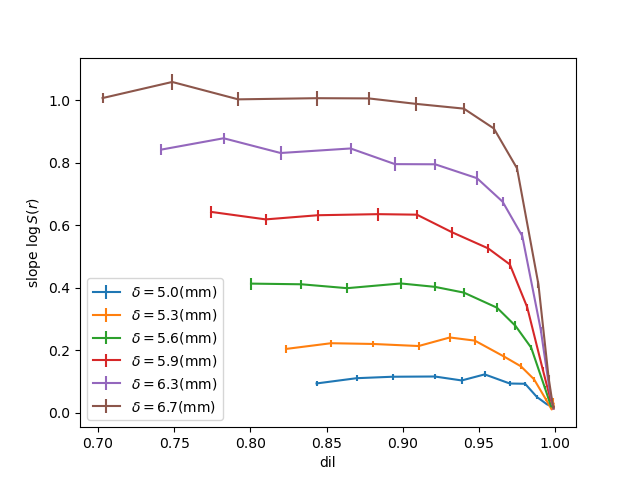

<IPython.core.display.Javascript object>


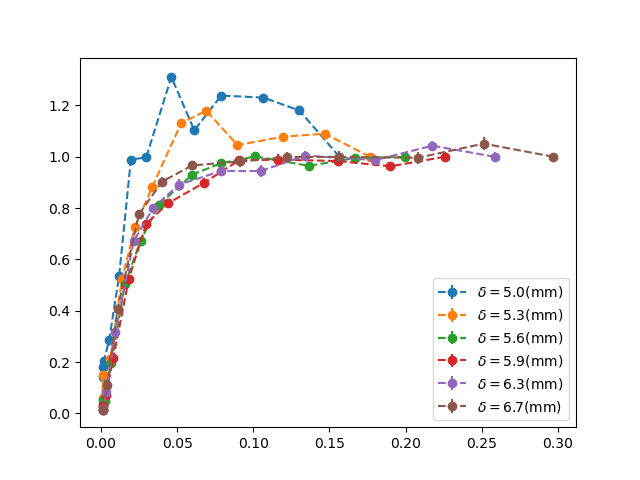

<IPython.core.display.Javascript object>


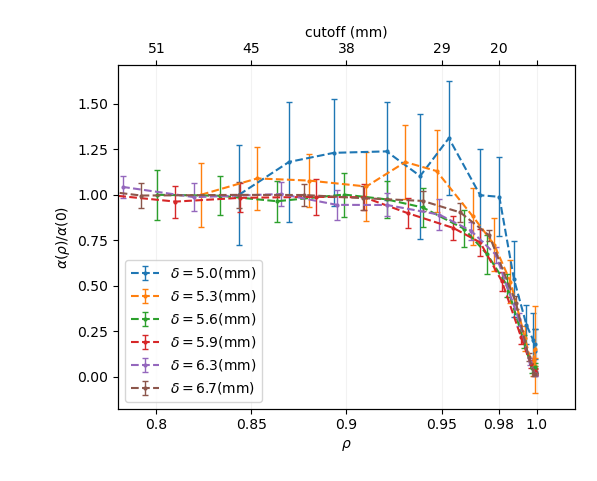

3.448275862068966
3.5714285714285725
3.703703703703705
3.846153846153848
4.000000000000002
4.166666666666668
4.347826086956522
4.545454545454547
4.761904761904763
5.000000000000001
[0.09333707801819671, 0.11017349175176465, 0.11484546151254109, 0.1155892644527261, 0.10294574063128159, 0.12237441941722449, 0.09311756961226172, 0.09229818149362368, 0.050119643207793295, 0.026649464415198054, 0.018932353064489236, 0.013274308345158258, 0.01682540517999274]
[1.         1.18038291 1.23043772 1.23840672 1.10294583 1.31110189
 0.99764822 0.98886941 0.53697463 0.28551852 0.2028385  0.14221903
 0.18026497]
5.263157894736843
[0.20391182225623491, 0.2222247594291055, 0.21984490986505167, 0.21321497791165295, 0.24059940908437477, 0.23053311432466356, 0.17969465966562387, 0.148179225173407, 0.10671922724284247, 0.04302964694259269, 0.009924872709118187, 0.03071070892895327, 0.01188607064362668]
[1.         1.08980812 1.07813714 1.04562342 1.17991888 1.13055296
 0.88123708 0.72668286 0.52335969 0.21

In [173]:
df = pd.read_csv('parametersRuns-autapse-thJ.csv')
#df = pd.read_csv('parametersRuns-autapse-thJ.csv')
#df['deltas'] = 1./df['lambdas'] 

def upper_tri_indexing(A):
    m = A.shape[0]
    print(m)
    r,c = np.triu_indices(m,1)
    print(r.shape)
    return A[r,c]

distUT = upper_tri_indexing(dist)
distSort = distUT.tolist()
distSort.sort()

deltas = np.unique(df['deltas'].values)
#ths = np.unique(df['thsRuns'].values)

f,ax0 = plt.subplots()
f,ax1 = plt.subplots()
f,ax2 = plt.subplots(figsize=(4,4))
mycols= plt.cm.autumn(np.linspace(0,1,len(ths)))

for i,delta in enumerate(deltas):
    print(delta)
    #print(df[df['thsRuns']==th])
    if (delta > 5.) and (delta < 7.): 
        dfdlt = df[df['deltas']==delta]
        #plt.figure()
        #plt.scatter(dfdlt['thsRuns'].values,dfdlt['dil'].values)
        #print(dfdlt)
        #ths = np.unique(dfdlt['thsRuns'].values)
        dils = np.unique(dfdlt['dilsRuns'].values)
        #print(ths)
        #print(ths.size,dils.size)
        alphaMean = []
        alphaSe = []
        alphaMean0 = None
        alphaNormMean = []
        alphaNormSe = []
        for dil in dils:
            #print(lamd)
            #print(df[df['lambdas'] == lamd]['alphaRuns'])
            alphas = dfdlt[dfdlt['dilsRuns'] == dil]['alphaRuns'].values
            alphas = alphas[np.isfinite(alphas)]
            #print(alphas)
            n = len(alphas)
            #print('n',n)
            alphaMean.append(np.mean(alphas))
            alphaSe.append(stats.sem(alphas))
            if alphaMean0 == None: 
                alphaMean0 = np.mean(alphas)
            alphaNormMean.append(np.mean(alphas/alphaMean0))
            alphaNormSe.append(stats.sem(alphas/alphaMean0))
        #print(len(alphaMean))
        #print(len(alphaSe))
        print(alphaMean)
        print(alphaMean/alphaMean[0])
        #f,ax0 = plt.subplots()
        #f,ax1 = plt.subplots()
        ax0.errorbar(dils, alphaMean, alphaSe, label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')#, color=mycols[i])
        ax1.errorbar(1-dils,alphaMean/alphaMean[0], alphaSe, marker='o',linestyle='--', label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')
        ax2.errorbar(dils,alphaNormMean, 3*np.array(alphaNormSe), marker='.',linestyle='--', 
                     markersize = 4. , elinewidth=1. , capsize=2, capthick=1.,
                     label=r'$\delta=$'+str(np.round(delta,1))+'(mm)',)
#ax0.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
#ax0.axvline(x = 0.18, color='r')
ax0.set_ylabel(r'slope $\log S(r)$')
ax0.set_xlabel(r'dil')
#ax0.set_xscale('log')
#ax2.set_xscale('log')
#ax0.axvline(x = 0.18, color='r')
ax2.set_ylabel(r'$\alpha(\rho)/\alpha(0)$')
ax2.set_xlabel(r'$\rho$')
ax0.legend()
ax1.legend()
ax2.legend()
ax2.grid(axis='x', color='0.95')
ax2b = ax2.twiny()
ax2.set_xticks([0.70,0.75,0.80,0.85,0.90,0.95,0.98,1.0])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.minorticks_off()
ax2.set_xticklabels([0.70,0.75,0.80,0.85,0.90,0.95,0.98,1.0])
#ax2b.set_xticks([0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.0,1.05])
#ax2b.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax2b.minorticks_off()
ax2b.set_xticks([0.70,0.75,0.80,0.85,0.90,0.95,0.98,1.0])
ax2b.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2b.minorticks_off()
distTh = [np.round(distSort[-int(499500*dil)],1) for dil in [0.70,0.75,0.80,0.85,0.90,0.95,0.98]]
distTh2 = ['%s' % int('%.2g' % d) for d in distTh]+['']
ax2b.set_xticklabels(distTh2)
ax2.set_xlim((0.78,1.02))
ax2b.set_xlim((0.78,1.02))
ax2b.set_xlabel(r'cutoff (mm)')
#ax2b.set_xlim((distSort[-int(499500*0.68)],distSort[-int(499500*1.02)]))
plt.tight_layout()

<IPython.core.display.Javascript object>


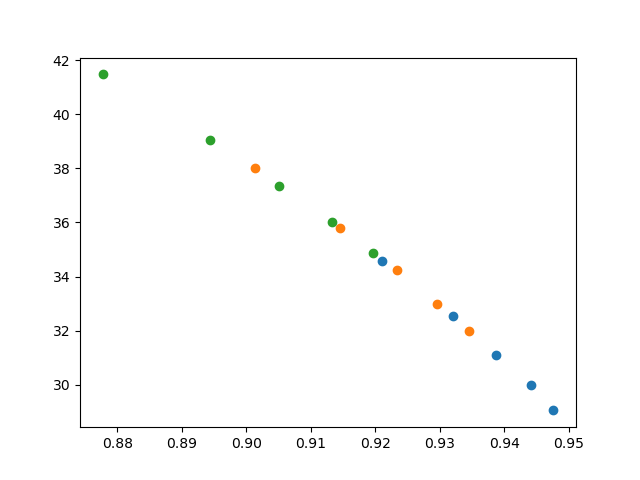

5 0.001 0.9210730730730731 34.583232931581165 34.698703145794944
5 0.0015 0.932066066066066 32.55764119219941 32.68026927673638
5 0.002 0.9387567567567567 31.11269837220809 31.304951684997057
5 0.0025 0.9440860860860861 30.0 30.133038346638727
5 0.003 0.9476216216216217 29.0516780926679 29.257477676655586
5.5 0.001 0.9012912912912913 38.0 38.05259518088089
5.5 0.0015 0.9145385385385385 35.77708763999664 35.888716889852724
5.5 0.002 0.9233293293293293 34.23448553724738 34.292856398964496
5.5 0.0025 0.9295595595595596 32.984845004941285 33.166247903554
5.5 0.003 0.9345585585585585 32.0 32.18695387886216
6 0.001 0.8776896896896897 41.47288270665544 41.66533331199932
6 0.0015 0.8942902902902903 39.03844259188627 39.191835884530846
6 0.002 0.905041041041041 37.36308338453881 37.416573867739416
6 0.0025 0.9132612612612613 36.0 36.11094017053558
6 0.003 0.9195655655655656 34.87119154832539 34.9857113690718


In [123]:
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

distUT = upper_tri_indexing(dist)
distSort = distUT.tolist()
distSort.sort()

plt.figure()
for delta in [5,5.5,6]:
    dils = []
    distsDil = []
    for th in [0.001,0.0015,0.002,0.0025,0.003]:#np.unique(df['thsRuns'].values):
        J = tb.makeJ(dist,1./delta,autapse,randomize)
        dil = (np.sum(J<th) - N) /(N*N - N)
        dmin = dist[dist>-np.log(th)*delta].min()
        distUT = upper_tri_indexing(dist)
        distSort 
        print(delta,th,dil,dmin,distSort[-int(499500*dil)])
        dils.append(dil)
        distsDil.append(dmin)
    plt.scatter(dils,distsDil)

In [152]:
def upper_tri_indexing(A):
    m = A.shape[0]
    print(m)
    r,c = np.triu_indices(m,1)
    print(r.shape)
    return A[r,c]

distUT = upper_tri_indexing(dist)
distSort = distUT.tolist()
distSort.sort()
print(distSort[-int(499500*0.9)])

print(distSort[-int(499500*1.)])

1000
(499500,)
38.262252939417984
4.47213595499958


In [154]:
distTh = [np.round(distSort[-int(499500*dil)],0) for dil in [0.70,0.75,0.80,0.85,0.90,0.95,1.]]

In [155]:
distTh

[62.0, 57.0, 51.0, 45.0, 38.0, 29.0, 4.0]

In [54]:
th = 0.2
dist[dist>-np.log(th)*5.55].min()

8.94427190999916

<IPython.core.display.Javascript object>


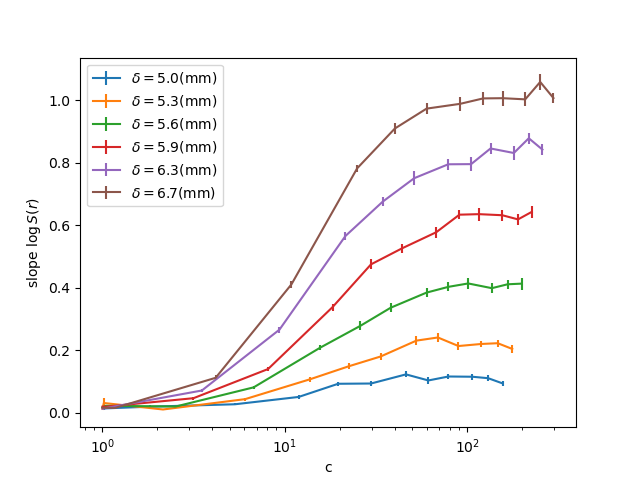

<IPython.core.display.Javascript object>


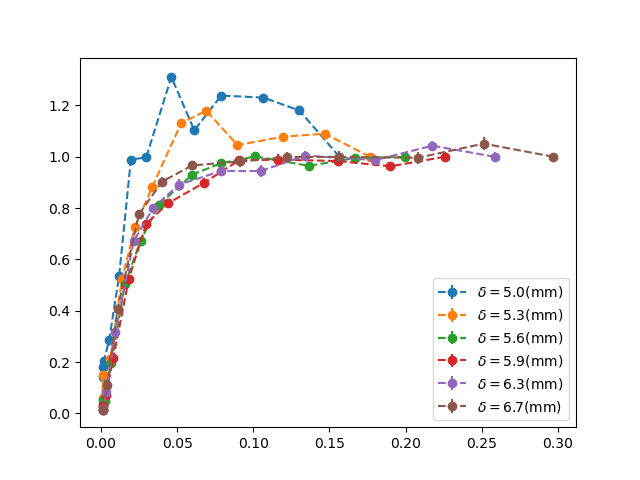

<IPython.core.display.Javascript object>


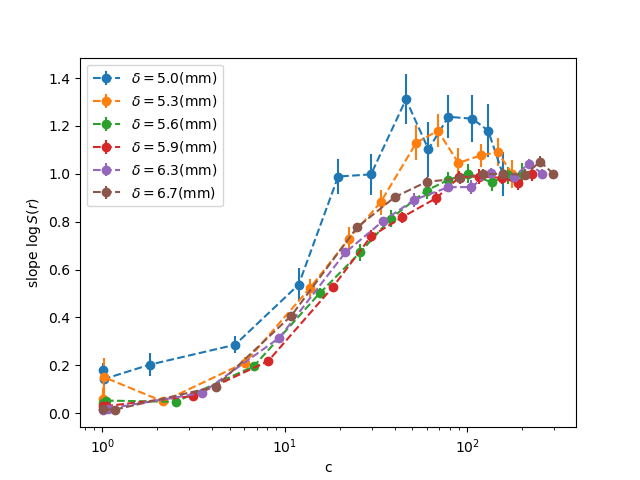

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

3.448275862068966
3.5714285714285725
3.703703703703705
3.846153846153848
4.000000000000002
4.166666666666668
4.347826086956522
4.545454545454547
4.761904761904763
5.000000000000001
[0.09333707801819671, 0.11017349175176465, 0.11484546151254109, 0.1155892644527261, 0.10294574063128159, 0.12237441941722449, 0.09311756961226172, 0.09229818149362368, 0.050119643207793295, 0.026649464415198054, 0.018932353064489236, 0.013274308345158258, 0.01682540517999274]
[1.         1.18038291 1.23043772 1.23840672 1.10294583 1.31110189
 0.99764822 0.98886941 0.53697463 0.28551852 0.2028385  0.14221903
 0.18026497]
5.263157894736843
[0.20391182225623491, 0.2222247594291055, 0.21984490986505167, 0.21321497791165295, 0.24059940908437477, 0.23053311432466356, 0.17969465966562387, 0.148179225173407, 0.10671922724284247, 0.04302964694259269, 0.009924872709118187, 0.03071070892895327, 0.01188607064362668]
[1.         1.08980812 1.07813714 1.04562342 1.17991888 1.13055296
 0.88123708 0.72668286 0.52335969 0.21

In [60]:
#df = pd.read_csv('parametersRuns-autapse-thJ.csv')
#df['deltas'] = 1./df['lambdas'] 

deltas = np.unique(df['deltas'].values)
#ths = np.unique(df['thsRuns'].values)

f,ax0 = plt.subplots()
f,ax1 = plt.subplots()
f,ax2 = plt.subplots()
mycols= plt.cm.autumn(np.linspace(0,1,len(ths)))

for i,delta in enumerate(deltas):
    print(delta)
    #print(df[df['thsRuns']==th])
    if (delta > 5.) and (delta < 7.): 
        dfdlt = df[df['deltas']==delta]
        #plt.figure()
        #plt.scatter(dfdlt['thsRuns'].values,dfdlt['dil'].values)
        #print(dfdlt)
        #ths = np.unique(dfdlt['thsRuns'].values)
        dils = np.unique(dfdlt['dilsRuns'].values)
        #print(ths)
        #print(ths.size,dils.size)
        alphaMean = []
        alphaSe = []
        alphaMean0 = None
        alphaNormMean = []
        alphaNormSe = []
        for dil in dils:
            #print(lamd)
            #print(df[df['lambdas'] == lamd]['alphaRuns'])
            alphas = dfdlt[dfdlt['dilsRuns'] == dil]['alphaRuns'].values
            alphas = alphas[np.isfinite(alphas)]
            #print(alphas)
            n = len(alphas)
            #print('n',n)
            alphaMean.append(np.mean(alphas))
            alphaSe.append(stats.sem(alphas))
            if alphaMean0 == None: 
                alphaMean0 = np.mean(alphas)
            alphaNormMean.append(np.mean(alphas/alphaMean0))
            alphaNormSe.append(stats.sem(alphas/alphaMean0))
        #print(len(alphaMean))
        #print(len(alphaSe))
        print(alphaMean)
        print(alphaMean/alphaMean[0])
        #f,ax0 = plt.subplots()
        #f,ax1 = plt.subplots()
        ax0.errorbar((1-dils)*N, alphaMean, alphaSe, label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')#, color=mycols[i])
        ax1.errorbar(1-dils,alphaMean/alphaMean[0], alphaSe, marker='o',linestyle='--', label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')
        ax2.errorbar((1-dils)*N,alphaNormMean, alphaNormSe, marker='o',linestyle='--', label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')
    #ax0.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    #ax0.axvline(x = 0.18, color='r')
    ax0.set_ylabel('slope $\log S(r)$')
    ax0.set_xlabel(r'c')
    ax0.set_xscale('log')
    ax2.set_xscale('log')
    #ax0.axvline(x = 0.18, color='r')
    ax2.set_ylabel('slope $\log S(r)$')
    ax2.set_xlabel(r'c')
    ax0.legend()
    ax1.legend()
    ax2.legend()

In [55]:
alphaMean/alphaMean[0]

array([1.        , 0.90414478, 0.77722553, 0.40794543, 0.11068308,
       0.01494289])

In [40]:
lambdas = np.unique(df['lambdas'].values)

In [41]:
delta = 0.5
dfdlt = df[df['deltas']==np.unique(df['deltas'])[9]]
ths = np.unique(dfdlt['thsRuns'].values)
ths

array([1.e-04, 2.e-04, 4.e-04, 1.e-03, 2.e-03, 4.e-03, 1.e-02, 2.e-02,
       4.e-02, 1.e-01, 2.e-01, 4.e-01])

In [80]:
 dils = np.unique(dfLmb['dil'].values)

5.000000000000003

time ij list 2.0860350131988525


<IPython.core.display.Javascript object>


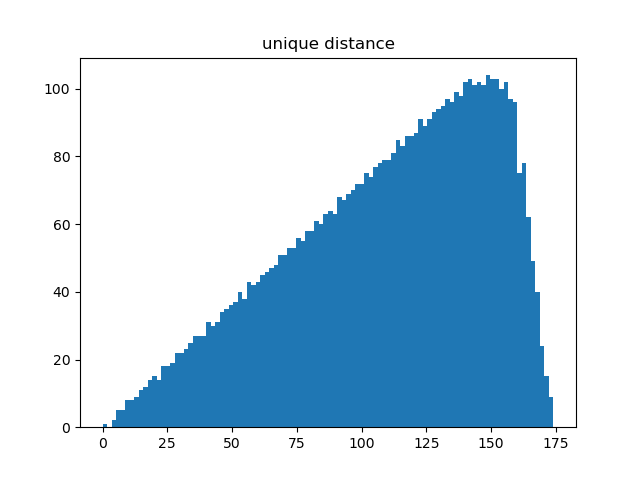

0.998998998998999


In [38]:
#import getCycles
import numpy as np
#import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
import time

import turboBrainUtils as tb 

runs = 40
passi = 100#200
autapse = True
randomize = False

# # Parcellizzazione
# https://www.sciencedirect.com/science/article/pii/S2211124720314601?via%3Dihub
df = pd.read_csv('Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
df.head()
X = df['R']
Y = df['A']
Z = df['S']
N=len(X)

coords = np.array([X,Y,Z]).T
dist = distance.cdist(coords, coords, 'euclidean')
uniqDist,iListList,jListList = tb.sortIJbyDist(dist,N)
plt.figure()
h,bins,f=plt.hist(uniqDist,bins=100)
plt.title('unique distance')

lamda = 0.2#0.18
J = tb.makeJ(dist,lamda,autapse,randomize)
#print(J[:4,:4], (J<thJ)[:4,:4], 'num cut',np.sum(J<thJ), thJ)
J[J<0.8] = 0.
dil = np.sum( (np.sum(J==0) - N) / ( N * N- N) ) 

print(dil)

In [27]:
J[1,2]

0.0

<IPython.core.display.Javascript object>


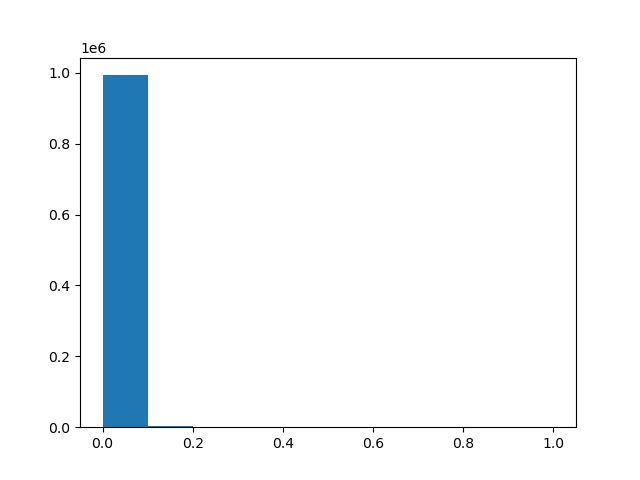

(array([9.93264e+05, 4.21800e+03, 1.16600e+03, 3.12000e+02, 4.00000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+03]),
 array([2.46381729e-14, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

In [17]:
plt.figure()
plt.hist(J.flatten())

In [21]:
np.sum(J>.80)

1000